In [1]:

#Importing all the relevant library
%matplotlib inline
import h5py, os
#from functions import transforms as T
#from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
import numpy as np
import torch
from matplotlib import pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
import glob
#from functions import transforms as T 
#from functions.subsample import MaskFunc
from PIL import Image
import random
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath

In [2]:
import torchvision.transforms as transforms

In [3]:
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn

def transform_kspace_to_image(k, dim=None, img_shape=None):
    """ Computes the Fourier transform from k-space to image space
    along a given or all dimensions
    :param k: k-space data
    :param dim: vector of dimensions to transform
    :param img_shape: desired shape of output image
    :returns: data in image space (along transformed dimensions)
    """
    if not dim:
        dim = range(k.ndim)

    img = fftshift(ifftn(ifftshift(k, axes=dim), s=img_shape, axes=dim), axes=dim)
    #img = fftshift(ifft2(ifftshift(k, dim=dim)), dim=dim)
    img *= np.sqrt(np.prod(np.take(img.shape, dim)))
    return img


def transform_image_to_kspace(img, dim=None, k_shape=None):
    """ Computes the Fourier transform from image space to k-space space
    along a given or all dimensions
    :param img: image space data
    :param dim: vector of dimensions to transform
    :param k_shape: desired shape of output k-space data
    :returns: data in k-space (along transformed dimensions)
    """
    if not dim:
        dim = range(img.ndim)

    k = fftshift(fftn(ifftshift(img, axes=dim), s=k_shape, axes=dim), axes=dim)
    #k = fftshift(fft2(ifftshift(img, dim=dim)), dim=dim)
    k /= np.sqrt(np.prod(np.take(img.shape, dim)))
    return k

In [4]:

def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [5]:
class MRIDataset(DataLoader):
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]

        return get_epoch_batch(subject_id)

In [6]:
import random
import numpy as np
from numpy.fft import fftshift, ifftshift, fftn, ifftn
import cmath
def noise_and_kspace(image):
    #change to k-space
    img_fft = fftshift(fftn(image))
    size_img = img_fft.shape
     #np.random.uniform, np.random.normal
    std = np.random.normal(0.000, 0.005) * np.amax(img_fft)
    noise = fftshift(std * np.random.standard_normal(size_img) + std * 1j * np.random.standard_normal(size_img));     #This generates a complex noise signal.
    img_fft_noise = img_fft + noise # k-space
    img_noise = ifftn(ifftshift(img_fft_noise))# revert k-space back to noise
    return img_noise

In [7]:
def get_epoch_batch(subject_id):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name = subject_id  
    
#    with h5py.File(rawdata_name, 'r') as data:
#        rawdata = data['kspace'][slice]
   
    im_frame = Image.open(rawdata_name)
    noise_im_frame = noise_and_kspace(im_frame)

    ############################
    #img_und = to_tensor(np.array(noise_im_frame)).unsqueeze(0) # noise image tensor form    
    preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum #64
                           T.CenterCrop(64),
                           T.ToTensor() #,
                            ])
    img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
    img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    
    n1 = (img_und**2).sum(dim=-1).sqrt()
    norm = n1.max() 
    if norm < 1e-6: norm = 1e-6
    
    img_gt, img_und = img_gt/norm , img_und/norm

    return img_gt.squeeze(0), img_und.squeeze(0)

In [8]:
def load_data_path(train_data_path, val_data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    data_path = [train_data_path, val_data_path]
      
    for i in range(len(data_path)):

        data_list[train_and_val[i]] = []
        
        which_data_path = data_path[i]
        tr = 0
        te = 0
        alfa = 0
    
        for fname in sorted(os.listdir(which_data_path)):
            if fname == '.DS_Store': continue
            
            subject_data_path = os.path.join(which_data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue 
            
     
            #get information from text file
            # this will return a tuple of root and extension
            split_tup = os.path.splitext(fname)

  
            # extract the file name and extension
            file_name = split_tup[0]
  
                
            # the first 5 slices are mostly noise so it is better to exlude them
            data_list[train_and_val[i]].append((fname, subject_data_path))
    
    return data_list

# RestNet

In [9]:
class baseBlock(torch.nn.Module):
    expansion = 1
    def __init__(self,input_planes,planes,stride=1,dim_change=None):
        super(baseBlock,self).__init__()
        #declare convolutional layers with batch norms
        self.conv1 = torch.nn.Conv2d(input_planes,planes,stride=stride,kernel_size=3,padding=1)
        self.bn1   = torch.nn.BatchNorm2d(planes)
        self.conv2 = torch.nn.Conv2d(planes,planes,stride=1,kernel_size=3,padding=1)
        self.bn2   = torch.nn.BatchNorm2d(planes)
        self.dim_change = dim_change
    def forward(self,x):
        #Save the residue
        res = x
        output = F.relu(self.bn1(self.conv1(x)))
        output = self.bn2(self.conv2(output))
        if self.dim_change is not None:
            res = self.dim_change(res)
        
        output += res
        output = F.relu(output)

        return output

class ResNet(torch.nn.Module):
    def __init__(self,block,num_layers,classes=10):
        super(ResNet,self).__init__()
        #according to research paper:
        self.input_planes = 64 #256
        self.conv1 = torch.nn.Conv2d(1,64,kernel_size=3,stride=1,padding=1)
        self.layer1 = self._layer(block,64,num_layers[0],stride=1)
        self.layer2 = self._layer(block,64,num_layers[1],stride=1)
        self.layer3 = self._layer(block,64,num_layers[2],stride=1)
        self.layer4 = self._layer(block,64,num_layers[3],stride=1)
        self.layer5 = self._layer(block,64,num_layers[3],stride=1)
        self.layer6 = self._layer(block,64,num_layers[3],stride=1)
        self.layer7 = self._layer(block,64,num_layers[3],stride=1)
        self.layer8 = self._layer(block,64,num_layers[2],stride=1)
        self.layer9 = self._layer(block,64,num_layers[3],stride=1)
        self.layer10 = self._layer(block,64,num_layers[3],stride=1)
       # self.layer11 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer12 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer13 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer14 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer15 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer16 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer17 = self._layer(block,64,num_layers[3],stride=1)
        #self.layer18 = self._layer(block,64,num_layers[3],stride=1)
        self.conv2 = torch.nn.Conv2d(64,1,kernel_size=3,stride=1, padding=1)
        
    
    def _layer(self,block,planes,num_layers,stride=1):
        dim_change = None
        if stride!=1 or planes != self.input_planes*block.expansion:
            dim_change = torch.nn.Sequential(torch.nn.Conv2d(self.input_planes,planes*block.expansion,kernel_size=1,stride=stride),
                                             torch.nn.BatchNorm2d(planes*block.expansion))
        netLayers =[]
        netLayers.append(block(self.input_planes,planes,stride=stride,dim_change=dim_change))
        self.input_planes = planes * block.expansion
        for i in range(1,num_layers):
            netLayers.append(block(self.input_planes,planes))
            self.input_planes = planes * block.expansion
        
        return torch.nn.Sequential(*netLayers)

    def forward(self,x):
        x = F.relu(self.conv1(x))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
     #   x = self.layer11(x)
      #  x = self.layer12(x)
      #  x = self.layer13(x)
     #   x = self.layer14(x)
      #  x = self.layer15(x)
     #   x = self.layer16(x)
     #   x = self.layer17(x)
     #   x = self.layer18(x)
        x = self.conv2(x)

        return x

In [10]:
from skimage.metrics import structural_similarity as cmp_ssim 
from skimage.metrics import mean_squared_error
from skimage.metrics import normalized_root_mse
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
         gt, pred, multichannel=False, data_range=gt.max()
    )
#def ssim(gt, pred):
#    """ Compute Structural Similarity Index Metric (SSIM). """
#    return cmp_ssim(
 #       gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
 #   )
def mse(gt, pred):
    """ Compute mean squared error. """
    return mean_squared_error(gt, pred)

def nrmse(gt, pred):
    """ Compute normalized root mse. """
    return normalized_root_mse(gt, pred)

In [11]:

    
data_path_train = 'dataBrain'
data_path_val = 'dataBrain'
data_list = load_data_path(data_path_train, data_path_val)
    

num_workers = 12 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
#mae_loss = nn.L1Loss().to('cuda:0')
mae_loss = nn.L1Loss()
lr = 0.0001 # 3e-3
    #acc =8 , network_8fold
network_8fold = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#network_8fold.to('cuda:0') #move the model on the GPU

    
optimizer2 = optim.Adam(network_8fold.parameters(), lr=lr)

 
train_dataset = MRIDataset(data_list['train'])
val_dataset = MRIDataset(data_list['val'])

train_loader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=num_workers) 
print("finish data loading- now train")
 

finish data loading- now train


In [12]:
network_8fold

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [13]:
import time
import random

then = time.time() #Time before the operations start
losses2=[]
mean_loss_list = []
img_nr = 0
epoch_nums = 80 #64 # 5
for epoch in range(epoch_nums):
    for iteration, sample in enumerate(train_loader):
        img_nr += 1
        img_gt, img_und = sample
        
        img_gt = img_gt.unsqueeze(1)#.to('cuda:0') # img_gt = img_gt.unsqueeze(1).to('cuda:0')
        img_und = img_und.unsqueeze(1)#.to('cuda:0') #img_und = img_und.unsqueeze(1).to('cuda:0')
       # img_gt = img_gt.to('cuda:0')
       # img_und = img_und.to('cuda:0')
            
        output = network_8fold(img_und)      #feedforward
        #print(output.shape) #// debug
        loss = mae_loss(output, img_gt)

        optimizer2.zero_grad()       #set current gradients to 0
        loss.backward()      #backpropagate
        optimizer2.step()     #update the weights
        mean_loss_list.append(loss.item())
       # print("Loss value: ", loss.item())
            #compute and print the mean L1 lossscore for the last 20 training images.
        if img_nr%20 == 0:
            print("L1 Loss score: ", np.round(np.mean(mean_loss_list), decimals = 5), "  Image number: ", img_nr, "  Epoch: ", epoch+1)
            mean_loss_list = []
        losses2.append(loss.item() * img_gt.size(0))
        
now = time.time() #Time after it finished

print("It took: ", now-then, " seconds")

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.50627   Image number:  20   Epoch:  1


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.12291   Image number:  40   Epoch:  2


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.09697   Image number:  60   Epoch:  3
L1 Loss score:  0.08018   Image number:  80   Epoch:  3


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08143   Image number:  100   Epoch:  4


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08223   Image number:  120   Epoch:  5


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08652   Image number:  140   Epoch:  6
L1 Loss score:  0.0797   Image number:  160   Epoch:  6


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.09528   Image number:  180   Epoch:  7


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.08043   Image number:  200   Epoch:  8


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06806   Image number:  220   Epoch:  9
L1 Loss score:  0.06934   Image number:  240   Epoch:  9


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06483   Image number:  260   Epoch:  10


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06009   Image number:  280   Epoch:  11


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.07124   Image number:  300   Epoch:  12
L1 Loss score:  0.06978   Image number:  320   Epoch:  12


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06222   Image number:  340   Epoch:  13


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.07148   Image number:  360   Epoch:  14


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05623   Image number:  380   Epoch:  15
L1 Loss score:  0.05088   Image number:  400   Epoch:  15


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0531   Image number:  420   Epoch:  16


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.07195   Image number:  440   Epoch:  17


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05993   Image number:  460   Epoch:  18
L1 Loss score:  0.05274   Image number:  480   Epoch:  18


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0489   Image number:  500   Epoch:  19


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04927   Image number:  520   Epoch:  20
L1 Loss score:  0.0452   Image number:  540   Epoch:  20


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05037   Image number:  560   Epoch:  21


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0586   Image number:  580   Epoch:  22


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05607   Image number:  600   Epoch:  23
L1 Loss score:  0.05218   Image number:  620   Epoch:  23


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06157   Image number:  640   Epoch:  24


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05757   Image number:  660   Epoch:  25


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.05081   Image number:  680   Epoch:  26
L1 Loss score:  0.04948   Image number:  700   Epoch:  26


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04903   Image number:  720   Epoch:  27


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0573   Image number:  740   Epoch:  28


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.06075   Image number:  760   Epoch:  29
L1 Loss score:  0.05142   Image number:  780   Epoch:  29


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04423   Image number:  800   Epoch:  30


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04195   Image number:  820   Epoch:  31


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04336   Image number:  840   Epoch:  32
L1 Loss score:  0.04842   Image number:  860   Epoch:  32


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04507   Image number:  880   Epoch:  33


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04743   Image number:  900   Epoch:  34


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04481   Image number:  920   Epoch:  35
L1 Loss score:  0.04143   Image number:  940   Epoch:  35


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0471   Image number:  960   Epoch:  36


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0491   Image number:  980   Epoch:  37


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04182   Image number:  1000   Epoch:  38
L1 Loss score:  0.03953   Image number:  1020   Epoch:  38


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03994   Image number:  1040   Epoch:  39


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03883   Image number:  1060   Epoch:  40
L1 Loss score:  0.0416   Image number:  1080   Epoch:  40


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03755   Image number:  1100   Epoch:  41


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04156   Image number:  1120   Epoch:  42


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04074   Image number:  1140   Epoch:  43
L1 Loss score:  0.04033   Image number:  1160   Epoch:  43


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04187   Image number:  1180   Epoch:  44


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04054   Image number:  1200   Epoch:  45


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0421   Image number:  1220   Epoch:  46
L1 Loss score:  0.03564   Image number:  1240   Epoch:  46


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04041   Image number:  1260   Epoch:  47


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04266   Image number:  1280   Epoch:  48


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03851   Image number:  1300   Epoch:  49
L1 Loss score:  0.03655   Image number:  1320   Epoch:  49


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03463   Image number:  1340   Epoch:  50


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03364   Image number:  1360   Epoch:  51


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03578   Image number:  1380   Epoch:  52
L1 Loss score:  0.03722   Image number:  1400   Epoch:  52


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03841   Image number:  1420   Epoch:  53


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03517   Image number:  1440   Epoch:  54


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03488   Image number:  1460   Epoch:  55
L1 Loss score:  0.03369   Image number:  1480   Epoch:  55


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03431   Image number:  1500   Epoch:  56


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03333   Image number:  1520   Epoch:  57


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03108   Image number:  1540   Epoch:  58
L1 Loss score:  0.03196   Image number:  1560   Epoch:  58


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03026   Image number:  1580   Epoch:  59


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02915   Image number:  1600   Epoch:  60
L1 Loss score:  0.02999   Image number:  1620   Epoch:  60


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03055   Image number:  1640   Epoch:  61


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03289   Image number:  1660   Epoch:  62


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03257   Image number:  1680   Epoch:  63
L1 Loss score:  0.0382   Image number:  1700   Epoch:  63


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04067   Image number:  1720   Epoch:  64


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.04191   Image number:  1740   Epoch:  65


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03857   Image number:  1760   Epoch:  66
L1 Loss score:  0.03664   Image number:  1780   Epoch:  66


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03697   Image number:  1800   Epoch:  67


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02983   Image number:  1820   Epoch:  68


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03572   Image number:  1840   Epoch:  69
L1 Loss score:  0.03879   Image number:  1860   Epoch:  69


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03808   Image number:  1880   Epoch:  70


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03434   Image number:  1900   Epoch:  71


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03401   Image number:  1920   Epoch:  72
L1 Loss score:  0.03221   Image number:  1940   Epoch:  72


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03225   Image number:  1960   Epoch:  73


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03212   Image number:  1980   Epoch:  74


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03073   Image number:  2000   Epoch:  75
L1 Loss score:  0.02896   Image number:  2020   Epoch:  75


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02824   Image number:  2040   Epoch:  76


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.0269   Image number:  2060   Epoch:  77


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.02666   Image number:  2080   Epoch:  78
L1 Loss score:  0.02674   Image number:  2100   Epoch:  78


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03259   Image number:  2120   Epoch:  79


/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part
/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex

L1 Loss score:  0.03281   Image number:  2140   Epoch:  80
L1 Loss score:  0.03018   Image number:  2160   Epoch:  80
It took:  87312.76808309555  seconds


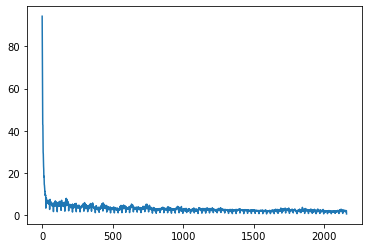

In [14]:
plt.plot(losses2)
plt.show()

In [15]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
NRMSE_improvement = []
NRMSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = network_8fold(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = torch.tensor(nrmse(gt, output))
    output_loss4 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = torch.tensor(nrmse(gt, image))
    image_loss4 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    NRMSE_improvement.append(output_loss3.item()-image_loss3.item())
    NRMSE_score.append(output_loss3.item())
    MIE_improvement.append(output_loss4 -image_loss4)
    MIE_score.append(output_loss4)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(NRMSE_improvement))
print(np.nanmean(NRMSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


0.1824071741887067
0.37923947877749375
-0.005968379193987214
0.0018148920604996648
-1.275852526897803
1.1477554617405503
-0.04759912
0.023053596


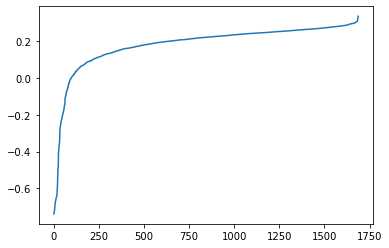

In [16]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

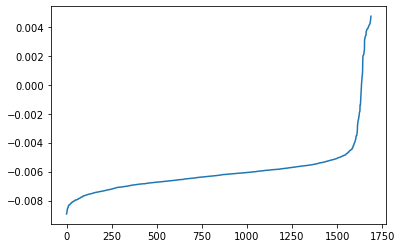

In [17]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

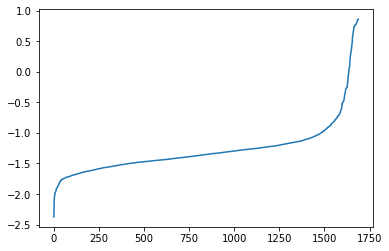

In [18]:
NRMSE_improvement.sort()
plt.plot(NRMSE_improvement)

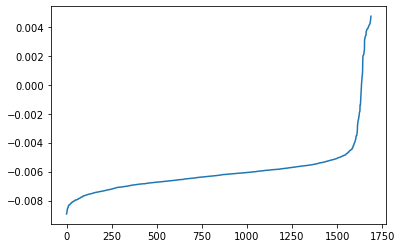

In [19]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

## save Model

In [20]:
index = 10

In [21]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-oasis-model{index}.pt"

In [22]:
#save model to S3 bucket or data
torch.save(network_8fold.state_dict(), output_dir)
#torch.save(network_8fold.state_dict(), './models/resnet18-model.pt')

## Load Model from saved model

In [ ]:
index = 10

In [ ]:
#output_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
output_dir = f"./network_8fold/restnet-oasis-model{index}.pt"

In [ ]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(output_dir, map_location=device))
model.eval()

## Predict a single image

In [23]:
index = 10

In [24]:
#model_dir = f"s3://savemodels/network_8fold/restnet-model{index}.pt"
model_dir = f"./network_8fold/restnet-oasis-model{index}.pt"

In [25]:
#load model on CPU: laptop
device = torch.device('cpu')
#model = TheModelClass(*args, **kwargs)
model = ResNet(baseBlock,[2, 2, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2])
#model.load_state_dict(torch.load(PATH, map_location=device))
model.load_state_dict(torch.load(model_dir, map_location=device))
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): baseBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): Ba

In [ ]:
#compute the SSIM score for every image after a feedforward propagation through 
#the network.
#Subtract the image SSIM score before the feedforward prop to obtain the net improvement for every image.
#Print the average improvement and the average SSIM score after the reconstruction.
SSIM_improvement = []
SSIM_score = []
MSE_improvement = []
MSE_score = []
MIE_improvement = []
MIE_score = []
for i in range(0,len(val_dataset)):
    gt, image = val_dataset[i]
    #image = image.unsqueeze(0).to('cuda:0')
    image = image.unsqueeze(0)
    image = image.unsqueeze(0)
    gt = gt.unsqueeze(0).numpy()
    output = model(image)
  #  output = output.squeeze(1).cpu().detach().numpy()
    output = output.squeeze(1).detach().numpy()
    image = image.squeeze(1).numpy()
    gt =  np.squeeze(gt)
    output =  np.squeeze(output)
    image =  np.squeeze(image)


    output_loss1 = torch.tensor(ssim(gt, output))
    output_loss2 = torch.tensor(mse(gt, output))
    output_loss3 = np.mean(np.abs(gt - output))
  #  image_loss = torch.tensor(ssim(gt, image.squeeze(1).cpu().numpy()))
    image_loss1 = torch.tensor(ssim(gt, image))
    image_loss2 = torch.tensor(mse(gt, image))
    image_loss3 = np.mean(np.abs(gt - image))
    SSIM_improvement.append(output_loss1.item()-image_loss1.item())
    SSIM_score.append(output_loss1.item())
    MSE_improvement.append(output_loss2.item()-image_loss2.item())
    MSE_score.append(output_loss2.item())
    MIE_improvement.append(output_loss3 -image_loss3)
    MIE_score.append(output_loss3)

print(np.nanmean(SSIM_improvement))
print(np.nanmean(SSIM_score))
print(np.nanmean(MSE_improvement))
print(np.nanmean(MSE_score))
print(np.nanmean(MIE_improvement))
print(np.nanmean(MIE_score))

In [ ]:
SSIM_improvement.sort()
plt.plot(SSIM_improvement)

In [ ]:
MSE_improvement.sort()
plt.plot(MSE_improvement)

In [ ]:
MIE_improvement.sort()
plt.plot(MSE_improvement)

In [42]:
from PIL import Image

In [26]:
file_dir = "dataBrain/OAS1_0365_MR1_mpr-1_anon_sag_66.png"

In [27]:
im_frame = Image.open(file_dir)
   
noise_im_frame = noise_and_kspace(im_frame)

preprocess = T.Compose([
                       # T.Grayscale(num_output_channels=1),
                           T.Resize(64),    #128 as maximum
                           T.CenterCrop(64),
                           T.ToTensor() #,
                           #T.Normalize(
                            #        mean=[0.485, 0.456, 0.406],
                               #        std=[0.229, 0.224, 0.225]
                             ##         )
                            ])
img_gt = preprocess(Image.fromarray(np.uint8(im_frame)).convert('L'))
img_und = preprocess(Image.fromarray(np.uint8(noise_im_frame)).convert('L'))
    
n1 = (img_und**2).sum(dim=-1).sqrt()
norm = n1.max() 
if norm < 1e-6: norm = 1e-6
    
img_gt, img_und = img_gt/norm , img_und/norm  
    




/Users/hoangvo/opt/anaconda3/envs/coursework/lib/python3.7/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


In [28]:
from skimage.metrics import structural_similarity as cmp_ssim 
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return cmp_ssim(
        gt, pred, multichannel=True, data_range=gt.max()
    )

In [29]:

img_und = img_und.unsqueeze(0)
output = model(img_und)
   # output = output.squeeze(1).cpu().detach().numpy()
output = output.squeeze(1).detach() #.numpy()   #image under numpy form


In [30]:
output.shape

torch.Size([1, 64, 64])

In [31]:
np_rescontruct_image =  output # np.reshape(output, (64, 64))# image noise numpy array
im_reconstruct = T.ToPILImage()(np_rescontruct_image)#Image.fromarray(np_rescontruct_image).convert('L')
im_reconstruct.save("testing/test.png") #for prediction values
im_reconstruct.save("pred1.png")

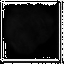

In [32]:
display(im_reconstruct)

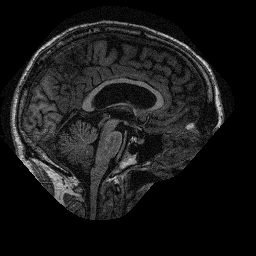

In [33]:
display(im_frame)

In [ ]:
display(Image.fromarray(np.uint8(noise_im_frame)))